#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

# General

##Imports and Install

In [ ]:
! pip install ray[tune] ax-platform sqlalchemy

     |████████████████████████████████| 23.1MB 1.2MB/s 
     |████████████████████████████████| 501kB 73.6MB/s 
     |████████████████████████████████| 1.3MB 65.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 2.9MB 58.4MB/s 
     |████████████████████████████████| 133kB 65.7MB/s 
     |████████████████████████████████| 204kB 63.4MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 317kB 48.0MB/s 
     |████████████████████████████████| 225kB 54.8MB/s 
     |████████████████████████████████| 143kB 73.7MB/s 
     |████████████████████████████████| 296kB 51.2MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 286kB 55.3MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=1ad72ec26411d915fb995b

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn

from ray import tune
from ray.tune.suggest.ax import AxSearch
from sklearn.model_selection import KFold, train_test_split
import random

##Dataset

In [ ]:
train_dataset = torchvision.datasets.MNIST('dataset', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('dataset', train=False, download=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

train_dataloader = None
val_dataloader = None

# Autoencoder

##Encoder and Decoder - Network Structure

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),   # (N, 1, 28, 28) -> (N, 8, 14, 14)
            nn.ReLU(),

            # Second convolutional layer
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),  # (N, 8, 14, 14) -> (N, 16, 7, 7)
            nn.ReLU(),

            # Third convolutional layer
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2), # (N, 16, 7, 7) -> (N, 32, 3, 3)
            nn.ReLU()
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)                     # (N, 32, 3, 3) -> (N, 288)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(288, 64),                                    # (N, 288) -> (N, 64)
            nn.ReLU(),

            # Second linear layer
            nn.Linear(64, encoded_space_dim)                       # (N, 64) -> (N, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)

        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(),
            
            # Second linear layer
            nn.Linear(64, 288),
            nn.ReLU()
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=0, output_padding=0, stride=2),
            nn.ReLU(),

            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),

            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1, output_padding=1, stride=2)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)

        # Apply transposed convolutions
        x = self.decoder_conv(x)

        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

##Training

###Training functions

In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(0)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor):
  # Set train mode for both the encoder and the decoder
  encoder.train()
  decoder.train()
    
  for image_batch, _ in dataloader:
    if noise_factor == 0:
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      
      # Encode data
      encoded_data = encoder(image_batch)

      # Decode data
      decoded_data = decoder(encoded_data)

      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)
    else:
      image_batch_noisy = image_batch + noise_factor * torch.randn(image_batch.shape)
      image_batch_noisy = np.clip(image_batch_noisy, 0., 1.)
      image_batch_noisy = image_batch_noisy.to(device)

      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      
      # Encode data
      encoded_data = encoder(image_batch_noisy)

      # Decode data
      decoded_data = decoder(encoded_data)

      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

  return loss.data

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
  # Set evaluation mode for encoder and decoder
  encoder.eval()
  decoder.eval()
  
  with torch.no_grad():
    # Define the lists to store the outputs for each batch
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
      # Move tensor to the proper device
      image_batch = image_batch.to(device)

      # Encode data
      encoded_data = encoder(image_batch)

      # Decode data
      decoded_data = decoder(encoded_data)
      
      # Append the network output and the original image to the lists
      conc_out.append(decoded_data.cpu())
      conc_label.append(image_batch.cpu())
    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    # Evaluate global loss
    val_loss = loss_fn(conc_out, conc_label)
  return val_loss.data

In [ ]:
def initialize(config):
  # Initialize the two networks
  encoder = Encoder(encoded_space_dim=config['encoded_space_dim'])
  decoder = Decoder(encoded_space_dim=config['encoded_space_dim'])

  # Define the loss function
  loss_fn = torch.nn.MSELoss()

  # Define an optimizer
  lr = config['lr']
  weight_decay = config['weight_decay']
  optimizer = config['optimizer']
  params_to_optimize = [
      {'params': encoder.parameters()},
      {'params': decoder.parameters()}
  ]

  #Adagrad = 1, RMSProp = 2, SGD = 3, AdaDelta = 4, Adam = 5
  if optimizer == 1:
    optim = torch.optim.Adagrad(params_to_optimize, lr=lr, weight_decay=weight_decay)
  elif optimizer == 2:
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=weight_decay)
  elif optimizer == 3:
    optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=weight_decay)
  elif optimizer == 4:
    optim = torch.optim.Adadelta(params_to_optimize, lr=lr, weight_decay=weight_decay)
  elif optimizer == 5:
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

  # Move both the encoder and the decoder to the selected device
  encoder.to(device)
  decoder.to(device)

  return encoder, decoder, loss_fn, optim

Train function used for non cross validation purposes and by the kcv function to run a cross validation training

In [ ]:
def train(config, train_dataloader_param=None, val_dataloader_param=None, fold=1, epochs=40, noise_factor=0):
  # Initilize the encoder, the decoder, the loss function and the optimizer
  encoder, decoder, loss_fn, optim = initialize(config)
  encoder.to(device)
  decoder.to(device)

  if optimization:
    if train_dataloader_param is None:
      global train_dataloader
      global val_dataloader
      train_dataloader_param = train_dataloader
      val_dataloader_param = val_dataloader
  else:
    train_dataloader_param = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle = True)

  train_loss = []
  val_loss = []

  for epoch in range(epochs):
    ### Training
    train_loss_epoch = train_epoch(
      encoder=encoder, 
      decoder=decoder, 
      device=device, 
      dataloader=train_dataloader_param, 
      loss_fn=loss_fn, 
      optimizer=optim,
      noise_factor=noise_factor)
    
    train_loss.append(train_loss_epoch)
    
    if optimization:
      ### Validation
      val_loss_epoch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader_param, 
        loss_fn=loss_fn)
      
      val_loss.append(val_loss_epoch)
    
    if optimization and kcv:
      print(f'FOLD {fold} EPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch} VALIDATION LOSS: {val_loss_epoch}')
    elif optimization and not kcv:
      tune.report(train_loss=train_loss_epoch, val_loss=val_loss_epoch)
      print(f'EPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch} VALIDATION LOSS: {val_loss_epoch}')
    else:
      print(f'\rEPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch}', end='')

  # If we are in the first fold
  if fold == 1:
    # Save network parameters
    model_name = f'lr={config["lr"]}-weight_decay={config["weight_decay"]}-batch_size={config["batch_size"]}'
    torch.save(encoder.state_dict(), f'encoder-{model_name}.pth')
    torch.save(decoder.state_dict(), f'decoder-{model_name}.pth')

  #if optimization and kcv:
  if optimization:
    return {'train_loss': train_loss, 'val_loss': val_loss}
  elif not optimization:
    print('\n') # Fix
    return encoder, decoder, train_loss

Funtion used for cross validation

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)
optimization = True
kcv = True

def kcv(config):
  folds = 5
  fold = 1
  train_loss = []
  val_loss = []
  kf = KFold(n_splits = folds, shuffle=True, random_state=42)

  for train_index, val_index in kf.split(train_dataset):
    train_dataset_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_dataset_subset = torch.utils.data.Subset(train_dataset, val_index)

    train_dataloader = DataLoader(train_dataset_subset, batch_size = 256, shuffle = False)
    val_dataloader = DataLoader(val_dataset_subset, batch_size = 256, shuffle = False)

    train_loss_fold, val_loss_fold = train(config, train_dataloader, val_dataloader, fold=fold)

    train_loss.append(train_loss_fold)
    val_loss.append(val_loss_fold)

    fold += 1

  train_loss_np = np.array(train_loss)
  val_loss_np = np.array(val_loss)

  train_loss_final = np.mean(train_loss_np, 0)
  val_loss_final = np.mean(val_loss_np, 0)

  for train_loss_final_epoch, val_loss_final_epoch in zip(train_loss_final, val_loss_final):
    tune.report(train_loss=train_loss_final_epoch, val_loss=val_loss_final_epoch)


def test(encoder, decoder):
  _, _, loss_fn, _ = initialize(config)
  test_loss = test_epoch(encoder, decoder, device, test_dataloader, loss_fn)
  print(f'TEST LOSS: {test_loss}')
  

###Hyper-parameters tuning (with cross validation)

In [ ]:
config = {
    'lr': tune.uniform(0.001, 0.005),
    'weight_decay': tune.uniform(1e-06, 2e-06),
    'batch_size': 1024,
}

# Turn on optimization mode
optimization = True
kvc = True

ax_search = AxSearch(metric="val_loss", mode="min")
analysis = tune.run(
    run_or_experiment=kcv,
    config=config,
    search_alg=ax_search,
    resources_per_trial={'gpu': 1}, 
    num_samples=200,
    metric='val_loss',
    mode='min',
    verbose=1
)

###Hyper-parameters tuning (without cross validation)

Hyper-parameters tuning without cross validation to choose the best optimizer

In [ ]:
# First broader search
config = {
    'lr': tune.uniform(0.001, 0.010),
    'weight_decay': tune.uniform(1e-06, 3e-06),
    'batch_size': 1024,
    'encoded_space_dim': tune.choice([2, 3, 4, 5]),
    'optimizer': tune.choice([1, 2, 3, 4, 5]) #Adagrad = 1, RMSProp = 2, SGD = 3, AdaDelta = 4, Adam = 5
}

# Second search
config = {
    "lr": tune.uniform(0.001, 0.005),
    "weight_decay": tune.uniform(1e-06, 2e-06),
    'batch_size': 1024,
    'encoded_space_dim': tune.choice([2, 3, 4, 5]),
    'optimizer': tune.choice([1, 2, 3, 4, 5]) #Adagrad = 1, RMSProp = 2, SGD = 3, AdaDelta = 4, Adam = 5
}

train_dataset_split, val_dataset_split = train_test_split(train_dataset, test_size=0.20, random_state=0)
train_dataloader = DataLoader(train_dataset_split, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset_split, batch_size=len(val_dataset_split), shuffle=True)

# Turn on optimization mode
optimization = True
kcv = False

ax_search = AxSearch(metric="val_loss", mode="min")
analysis = tune.run(
    run_or_experiment=train,
    config=config,
    search_alg=ax_search,
    resources_per_trial={'gpu': 1}, 
    num_samples=200,
    metric='val_loss',
    mode='min',
    verbose=1
)

Hyper-parameters tuning without cross validation to choose the best hyper-parameters values with the best optimizer found in the first tuning (Adam)

In [ ]:
# Third search with only Adam optimizer
config = {
    'lr': tune.uniform(0.001, 0.005),
    'weight_decay': tune.uniform(1e-06, 2e-06),
    'batch_size': 1024,
    'encoded_space_dim': tune.choice([2, 3, 4, 5]),
    'optimizer': 5 # Adam
}

train_dataset_split, val_dataset_split = train_test_split(train_dataset, test_size=0.20, random_state=0)
train_dataloader = DataLoader(train_dataset_split, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset_split, batch_size=len(val_dataset_split), shuffle=True)

# Turn on optimization mode
optimization = True
kcv = False

ax_search = AxSearch(metric="val_loss", mode="min")
analysis = tune.run(
    run_or_experiment=train,
    config=config,
    search_alg=ax_search,
    resources_per_trial={'gpu': 1}, 
    num_samples=200,
    metric='val_loss',
    mode='min',
    verbose=1
)

Trial name,status,loc,batch_size,encoded_space_dim,lr,weight_decay,iter,total time (s)
train_2423562a,TERMINATED,,1024,3,0.00351881,1.45839e-06,40,306.993
train_31645eba,TERMINATED,,1024,2,0.00300595,1.56832e-06,40,301.694
train_f5d80044,TERMINATED,,1024,4,0.00159449,1.76312e-06,40,300.071
train_b7907a72,TERMINATED,,1024,2,0.00429845,1.1157e-06,40,299.295
train_778d9abc,TERMINATED,,1024,5,0.00151819,1.72051e-06,40,299.222
train_36f6d922,TERMINATED,,1024,3,0.00294128,1.54128e-06,40,299.649
train_f6c2ec14,TERMINATED,,1024,5,0.00489835,1.85849e-06,40,300.757
train_b7488d0e,TERMINATED,,1024,3,0.00355806,1.47839e-06,40,300.201
train_77ed941e,TERMINATED,,1024,2,0.00200252,1.28676e-06,40,301.234
train_388f6cce,TERMINATED,,1024,5,0.00399916,1.40644e-06,40,300.652


2020-12-08 02:43:10,287	INFO tune.py:439 -- Total run time: 64848.33 seconds (64839.82 seconds for the tuning loop).


###Final model
Training on all the dataset and testing the final model on the test set

In [ ]:
config = {
    'lr': 0.003378429651260376,
    'weight_decay': 1.4770454764366148e-06,
    'batch_size': 1024,
    'encoded_space_dim': 5,
    'optimizer': 5
}

optimization = False
kcv = False

encoder, decoder, train_loss = train(config, epochs=80)
test(encoder, decoder)

EPOCH 80/80 TRAIN LOSS: 0.024551449343562126

TEST LOSS: 0.02501760981976986


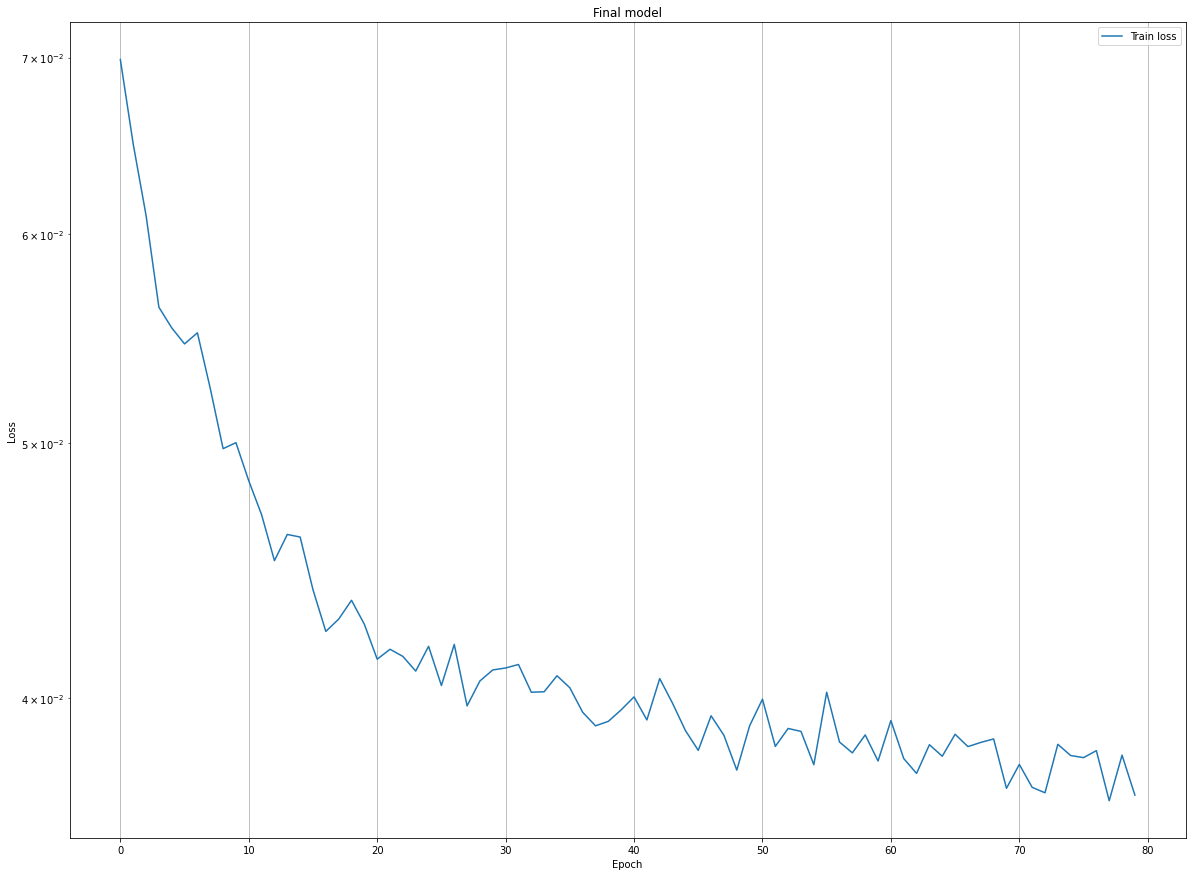

In [ ]:
plt.figure(figsize=(20,15))
plt.title('Final model')
plt.semilogy(train_loss, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

###Image recontruction

In [ ]:
def rec_img_show(idx):
  img = test_dataset[idx][0].unsqueeze(0).to(device)
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    rec_img  = decoder(encoder(img))

  # Plot the original image and the reconstructed one
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0].set_title('Original image')
  axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[1].set_title('Reconstructed image')
  plt.tight_layout()
  plt.show()

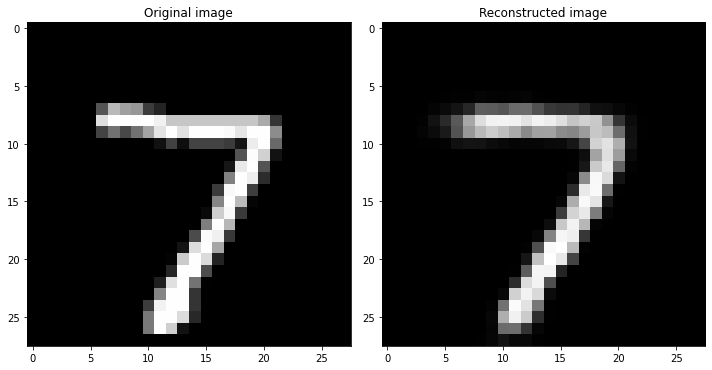

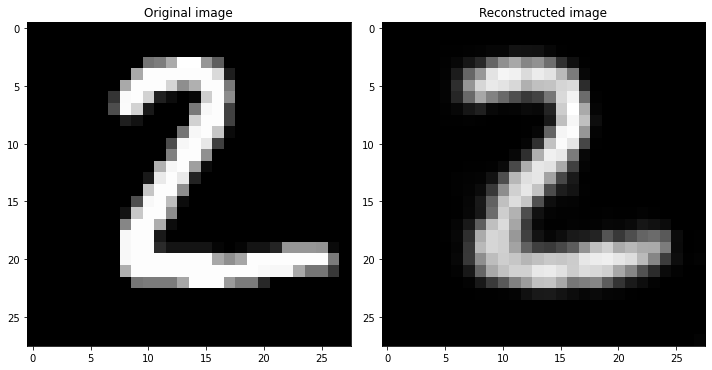

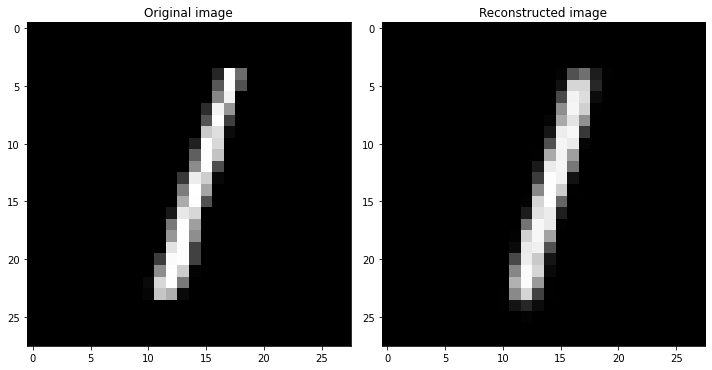

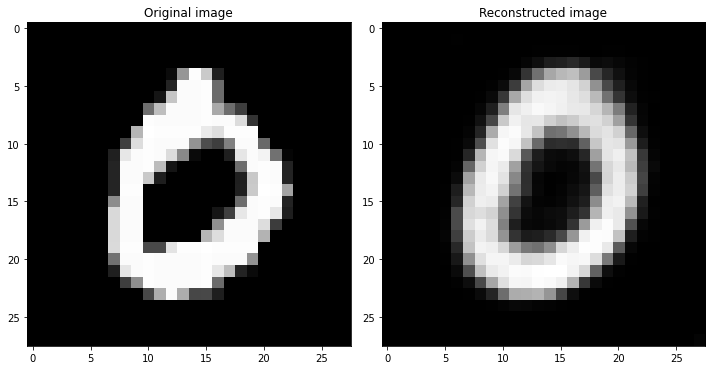

In [ ]:
rec_img_show(0)
rec_img_show(1)
rec_img_show(2)
rec_img_show(3)

##Denoiser

We have to train the model with a noise_factor, this enables the denoiser mode in the train function

In [ ]:
config = {
    'lr': 0.004911981344223023,
    'weight_decay': 1.5788808465003966e-06,
    'batch_size': 1024,
    'encoded_space_dim': 5,
    'optimizer': 5 #Adam
}

optimization = False
kcv = False

encoder, decoder, train_loss = train(config, epochs=40, noise_factor=0.3)
test(encoder, decoder)

EPOCH 40/40 TRAIN LOSS: 0.024539874866604805



In [ ]:
test(encoder, decoder)

TEST LOSS: 0.02461482211947441


In [ ]:
def rec_img_noisy_show(idx, noise_factor=0.3):
  img = test_dataset[idx][0].unsqueeze(0)
  img_noisy = img + noise_factor * torch.randn(img.shape)
  img_noisy = np.clip(img_noisy, 0., 1.)
  img_noisy = img_noisy.to(device)
  
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    rec_img  = decoder(encoder(img_noisy))
  
  # Plot the original image and the reconstructed one
  fig, axs = plt.subplots(1, 3, figsize=(10,5))
  axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0].set_title('Original image')
  axs[1].imshow(img_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[1].set_title('Noisy image')
  axs[2].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[2].set_title('Reconstructed image')
  plt.tight_layout()
  plt.show()

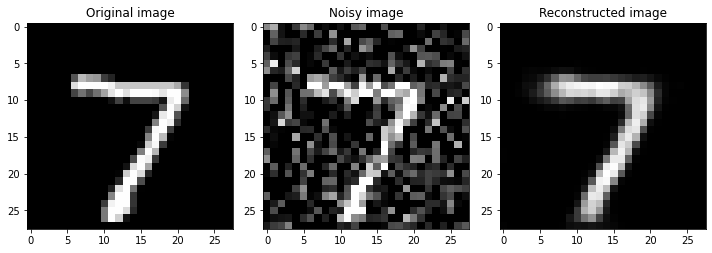

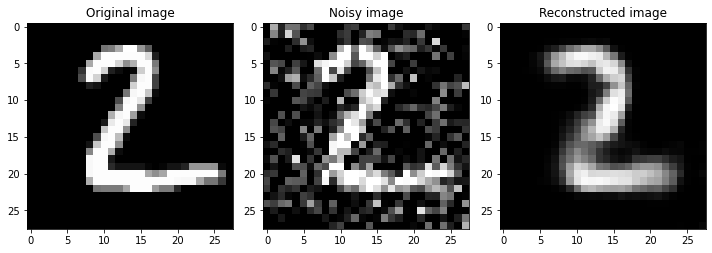

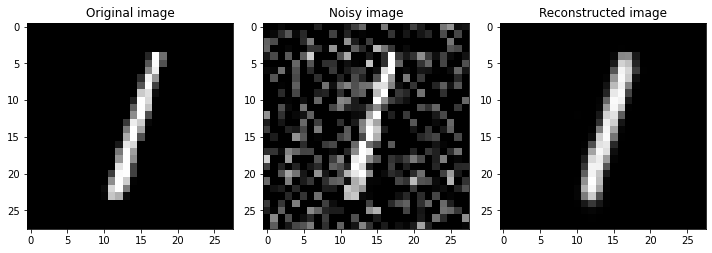

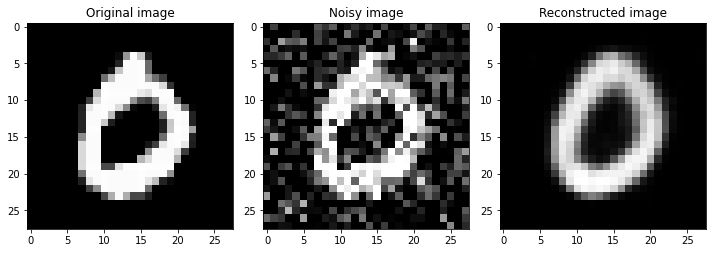

In [ ]:
rec_img_noisy_show(0)
rec_img_noisy_show(1)
rec_img_noisy_show(2)
rec_img_noisy_show(3)

We train the model again with an higer noise factor (0.6):

In [ ]:
config = {
    "lr": 0.004911981344223023,
    "weight_decay": 1.5788808465003966e-06,
    "batch_size": 1024,
    'encoded_space_dim': 5
}

optimization = False
kcv = False

encoder, decoder, train_loss = train(config, epochs=40, noise_factor=0.6)
test(encoder, decoder)

EPOCH 40/40 TRAIN LOSS: 0.03635215759277344

TEST LOSS: 0.033214837312698364


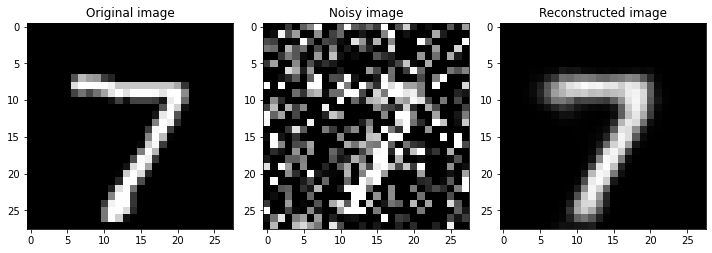

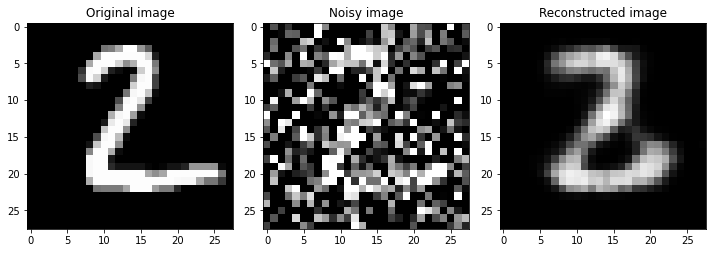

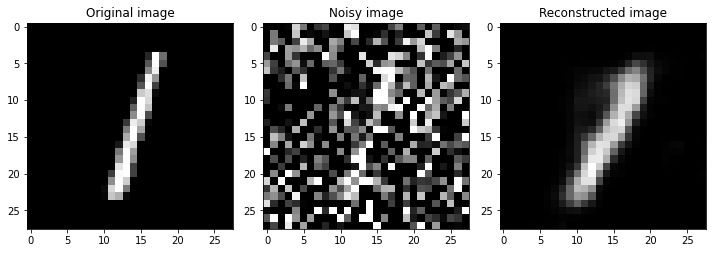

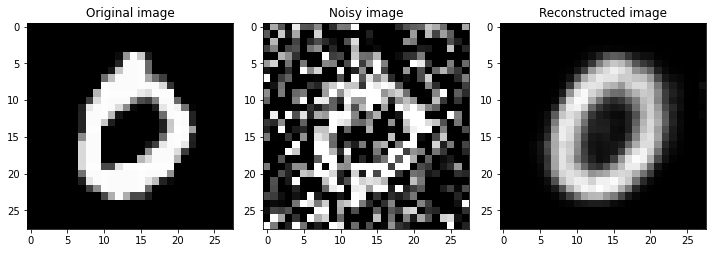

In [ ]:
rec_img_noisy_show(0, noise_factor=0.6)
rec_img_noisy_show(1, noise_factor=0.6)
rec_img_noisy_show(2, noise_factor=0.6)
rec_img_noisy_show(3, noise_factor=0.6)

##Dimensionality reduction method

In [ ]:
config = {
    'lr': 0.003378429651260376,
    'weight_decay': 1.4770454764366148e-06,
    'batch_size': 1024,
    'encoded_space_dim': 5,
    'optimizer': 5
}

optimization = False
kcv = False

encoder, decoder, train_loss = train(config, epochs=80)
test(encoder, decoder)

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
encoded_labels = []
for sample in test_dataset:
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]
  # Encode image
  encoder.eval()
  with torch.no_grad():
      encoded_img  = encoder(img)

  # Append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_labels.append(label)
  encoded_samples.append(encoded_img)

encoded_samples = np.array(encoded_samples)
encoded_labels = np.array(encoded_labels)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

encoded_samples_reduced = TSNE(n_components=2).fit_transform(encoded_samples)

px.scatter(encoded_samples_reduced, x=0, y=1, color=encoded_labels.astype(str), opacity=0.7, width=900, height=900)

##Samples from latent code

In [ ]:
config = {
    'lr': 0.003378429651260376,
    'weight_decay': 1.4770454764366148e-06,
    'batch_size': 1024,
    'encoded_space_dim': 5,
    'optimizer': 5
}

optimization = False
kcv = False

encoder, decoder, train_loss = train(config, epochs=80)
test(encoder, decoder)

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
encoded_labels = []
for sample in test_dataset:
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]
  # Encode image
  encoder.eval()
  with torch.no_grad():
      encoded_img  = encoder(img)

  # Append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_labels.append(label)
  encoded_samples.append(encoded_img)

encoded_samples = np.array(encoded_samples)
encoded_labels = np.array(encoded_labels)

This is the version with same min/max (see the report for explanation)

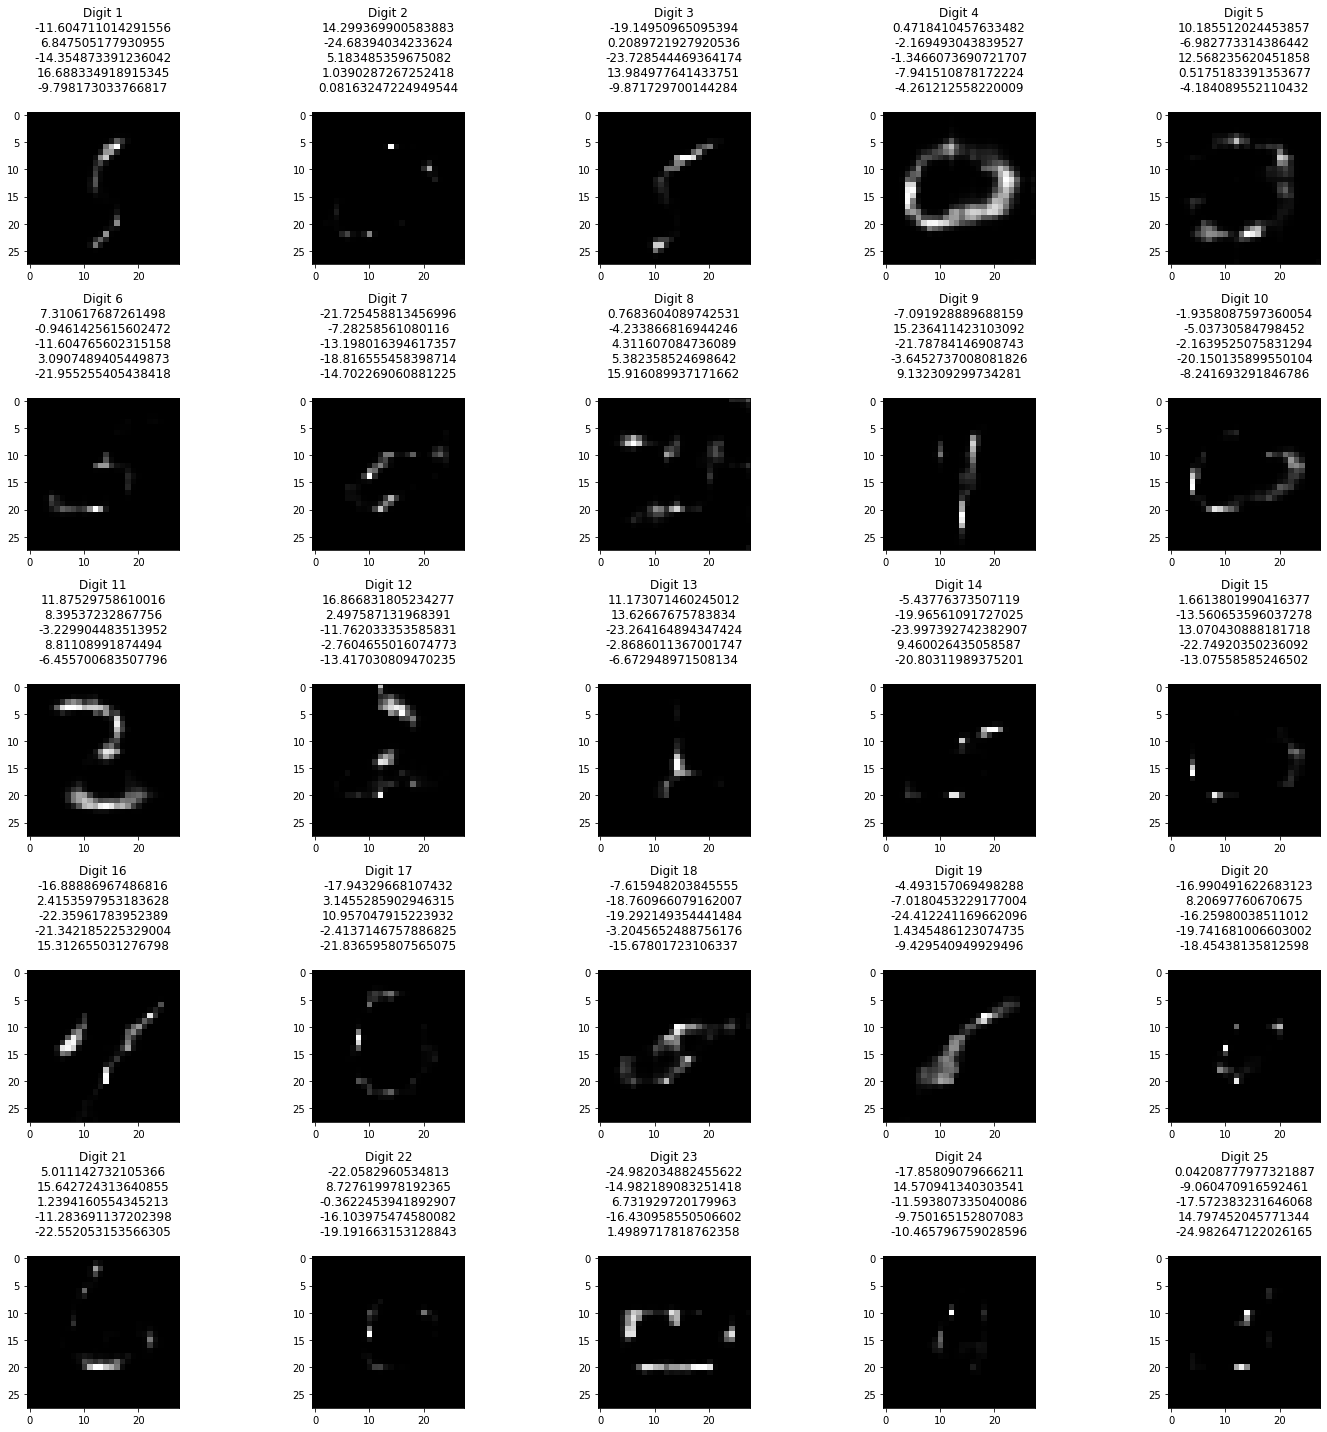

In [ ]:
max_value = max(map(max, encoded_samples))
min_value = min(map(min, encoded_samples))

def generate_code(dimensionality=5):
  code = []
  for idx in range(dimensionality):
    code.append(random.uniform(min_value, max_value))
  return code

def generate_img(code): 
  # Generate a custom sample
  encoded_value = torch.tensor(code).float().unsqueeze(0).to(device)

  # Decode sample
  decoder.eval()
  with torch.no_grad():
      generated_img  = decoder(encoded_value)

  return generated_img

def code_to_string(code):
  code_str = ''
  for x in code:
    code_str = code_str + str(x) + '\n'
  return code_str

def generate_img_grid():
  fig, axs = plt.subplots(5, 5, figsize=(20,20))
  idx = 1
  for i in range(5):
    for j in range(5):
      code = generate_code()
      axs[i][j].imshow(generate_img(code).cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i][j].set_title(f'Digit {idx}\n' + code_to_string(code))
      idx += 1
  plt.tight_layout()
  plt.show()

generate_img_grid()

This is the version with different min/max (see the report for explanation)

min [-15.080074, -8.372093, -25.522896, -14.559586, -10.792806]
max [9.3023405, 15.446811, 6.1077394, 12.1582365, 17.237045]


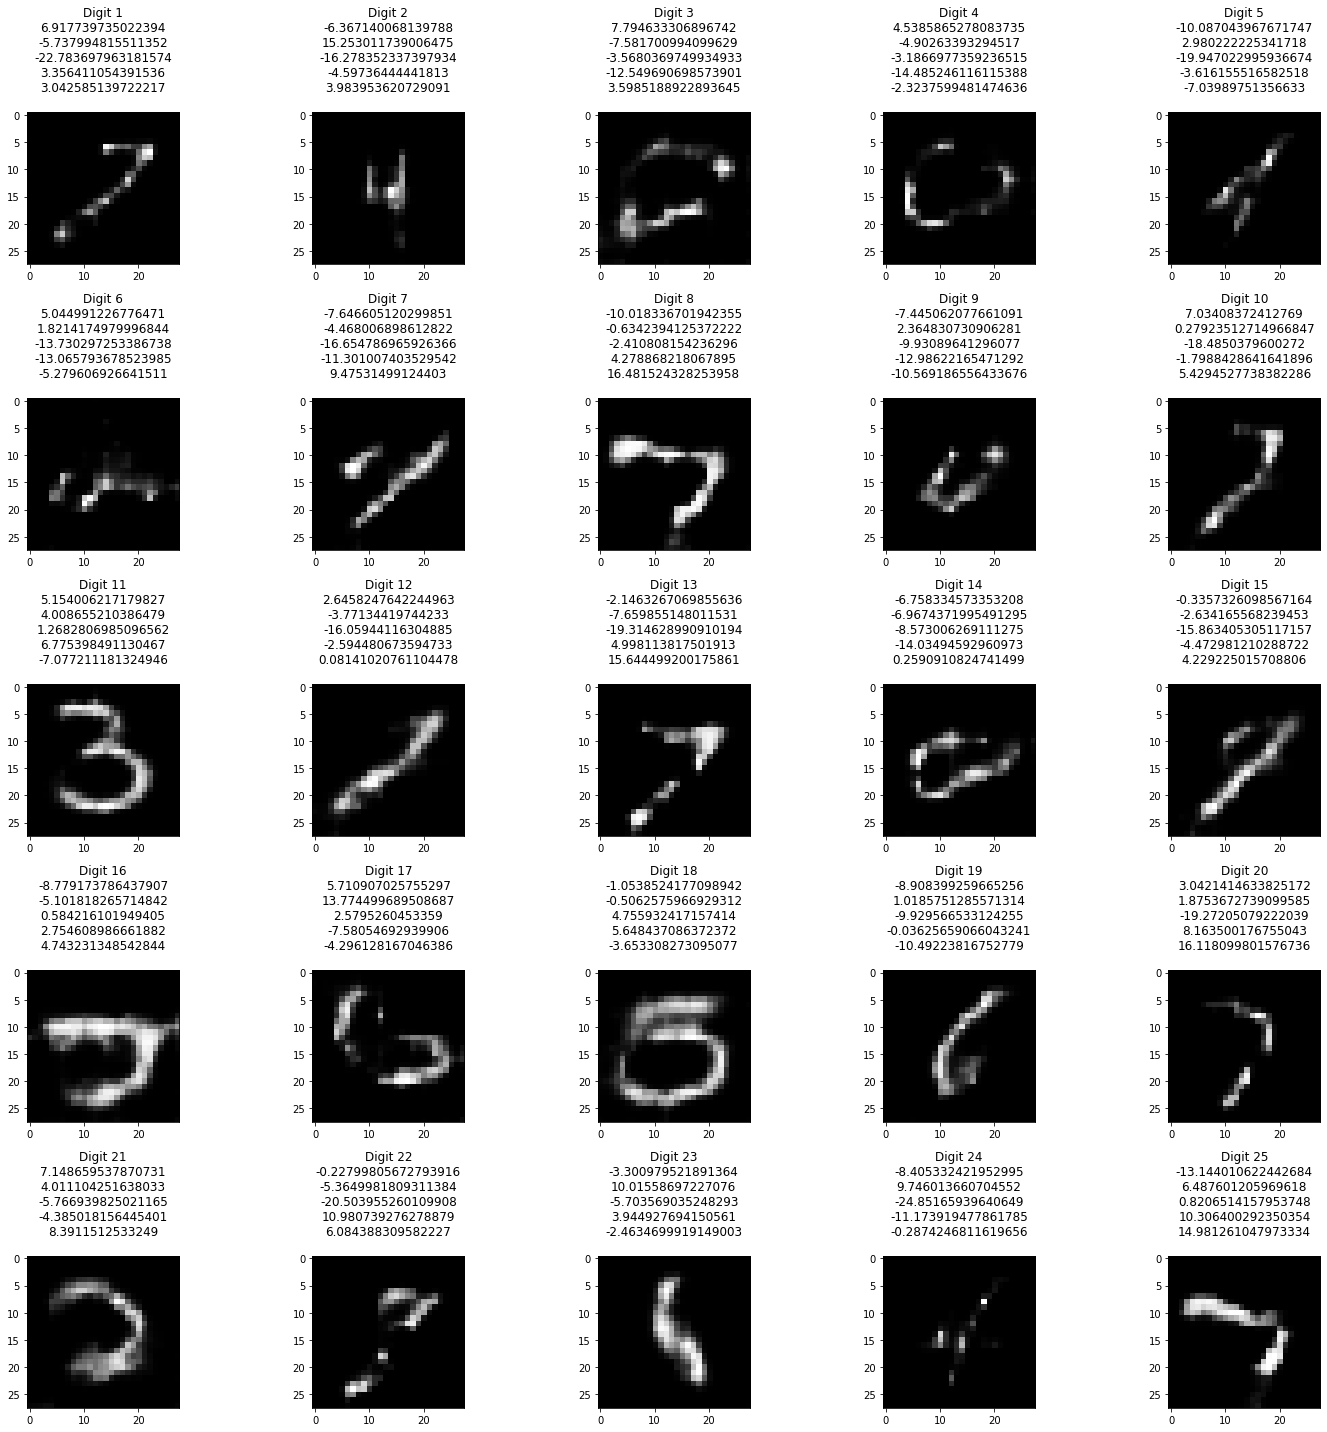

In [ ]:
max_value = []
min_value = []

def extract_extremes(dimensionality=5):
  for idx in range(dimensionality):
    ax = encoded_samples[:, idx]
    max_value.append(np.max(ax))
    min_value.append(np.min(ax))
  print('min', min_value)
  print('max', max_value)

def generate_code(dimensionality=5):
  code = []
  for idx in range(dimensionality):
    code.append(random.uniform(min_value[idx], max_value[idx]))
  return code

def generate_img(code): 
  # Generate a custom sample
  encoded_value = torch.tensor(code).float().unsqueeze(0).to(device)

  # Decode sample
  decoder.eval()
  with torch.no_grad():
      generated_img  = decoder(encoded_value)

  return generated_img

def code_to_string(code):
  code_str = ''
  for x in code:
    code_str = code_str + str(x) + '\n'
  return code_str

def generate_img_grid():
  fig, axs = plt.subplots(5, 5, figsize=(20,20))
  idx = 1
  for i in range(5):
    for j in range(5):
      code = generate_code()
      axs[i][j].imshow(generate_img(code).cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i][j].set_title(f'Digit {idx}\n' + code_to_string(code))
      idx += 1
  plt.tight_layout()
  plt.show()

extract_extremes()
generate_img_grid()

##Autoencoder Classifier

###Classifier - Network Structure

In [ ]:
class LatentClassifier(nn.Module):

  def __init__(self, encoded_space_dim):
    super().__init__()

    self.fc = nn.Sequential( 
      nn.Linear(in_features=encoded_space_dim, out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=10)
    )

    print('Network initialized')
  
  def forward(self, x):
    x = self.fc(x)

    return x

###Training - Encoder

I train the autoencoder again as we want the latent space to be of size 32 and not 5 as before. Explained in the report.

In [ ]:
config = {
    'lr': 0.004911981344223023,
    'weight_decay': 1.5788808465003966e-06,
    'batch_size': 1024,
    'encoded_space_dim': 32,
    'optimizer': 5
}

optimization = False
kcv = False

encoder, decoder, train_loss = train(config, epochs=80)
test(encoder, decoder)

EPOCH 80/80 TRAIN LOSS: 0.0072172763757407665

TEST LOSS: 0.00691730622202158


In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(0)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
### Training function
def train_epoch(net, device, dataloader, loss_fn, optimizer):
  # Set train mode for both the net
  net.train()
    
  train_loss = []
  for data_batch, label_batch in dataloader:
    # Move tensor to the proper device
    data_batch = data_batch.to(device)
    label_batch = label_batch.to(device, dtype=torch.int64)
    
    # Forward pass
    pred_label = net(data_batch)

    label_batch = label_batch.view(label_batch.shape[0])
    pred_label = pred_label.squeeze(-2)

    # Evaluate loss
    loss = loss_fn(pred_label, label_batch)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    #Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)

  return train_loss

In [ ]:
### Testing function
def test_epoch(net, device, dataloader, loss_fn):
  correct_count, all_count = 0, 0
  # Set evaluation mode for net
  net.eval()
  
  with torch.no_grad():
    for data_batch, label_batch in dataloader:
      # Move tensor to the proper device
      data_batch = data_batch.to(device)
      label_batch = label_batch.to(device)
      
      # Forward pass
      pred_label = net(data_batch)
      
      # Calculating right preditions 
      for idx, logps in enumerate(pred_label):
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy())
        pred_label = probab.index(max(probab))
        true_label = label_batch[idx].cpu()
        
        if true_label == pred_label:
          correct_count += 1
        all_count += 1

  # Save test accuracy
  test_acc = correct_count / all_count
  return test_acc

In [ ]:
def initialize(config):
  # Initialize the network
  net = LatentClassifier(encoded_space_dim=config['encoded_space_dim'])

  # Define the loss function
  loss_fn = torch.nn.CrossEntropyLoss()

  # Define an optimizer
  #optim = torch.optim.SGD(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
  optim = torch.optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

  # Move both the net to the selected device
  net.to(device)

  return net, loss_fn, optim

In [ ]:
optimization = False

def train(config, epochs=500):
  # Initilize the net, the loss function and the optimizer
  net, loss_fn, optim = initialize(config)

  train_dataloader = torch.utils.data.DataLoader(train_latent_dataset, batch_size=config["train_batch_size"], shuffle=True)

  train_loss = []
  val_loss = []

  for epoch in range(epochs):
    ### Training
    train_loss_epoch = train_epoch(
      net=net,  
      device=device, 
      dataloader=train_dataloader, 
      loss_fn=loss_fn, 
      optimizer=optim
    )
    
    train_loss.append(train_loss_epoch)
    
    if optimization:
      ### Validation
      val_loss_epoch = test_epoch(
        net=net,
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn
      )
      
      val_loss.append(val_loss_epoch)
    
    if optimization:
      print(f'EPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch} VALIDATION LOSS: {val_loss_epoch}')
    else:
      print(f'\rEPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch}', end='')

  # Save network parameters
  model_name = f'lr={config["lr"]}-weight_decay={config["weight_decay"]}-batch_size={config["train_batch_size"]}'
  torch.save(net.state_dict(), f'classifier-{model_name}.pth')

  if not optimization:
    print('\n') # Fix
    return net, train_loss

In [ ]:
def test(net):
  _, loss_fn, _ = initialize(config)
  test_dataloader = torch.utils.data.DataLoader(test_latent_dataset, batch_size=len(test_latent_dataset), shuffle=False)
  test_acc = test_epoch(net, device, test_dataloader, loss_fn)
  print(f'TEST ACCURACY: {test_acc}')

In [ ]:
class LatentDataset(Dataset):

  def __init__(self, encoded_samples):
    self.data = encoded_samples

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    latent_code = self.data[idx][0]
    label = self.data[idx][1]
    
    return (torch.Tensor(latent_code).float(), torch.Tensor([label]).float())

Get the latent space representations of test images

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in test_dataset:
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]
  # Encode image
  encoder.eval()
  with torch.no_grad():
    encoded_img  = encoder(img)

  # Append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  sample = (encoded_img.tolist(), label)
  encoded_samples.append(sample)

test_latent_dataset = LatentDataset(encoded_samples)

Training the Classifier and getting the test accuracy

In [ ]:
config = {
    'lr': 0.0001,
    'weight_decay': 0,
    'train_batch_size': 100,
    'encoded_space_dim': 32
}

classifier, train_loss = train(config, epochs=80) #Adam
test(classifier)

Network initialized
EPOCH 80/80 TRAIN LOSS: 0.03670418635010719

Network initialized
TEST LOSS: 0.9836


#Variational Autoencoder

##VAE - Network Structure

In [ ]:
class EncoderVAE(nn.Module):
    
  def __init__(self, encoded_space_dim):
    super().__init__()
    
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),   # (N, 1, 28, 28) -> (N, 8, 14, 14)
      nn.ReLU(),
      nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),  # (N, 8, 14, 14) -> (N, 16, 7, 7)
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2), # (N, 16, 7, 7) -> (N, 32, 3, 3)
      nn.ReLU(),
      nn.Flatten(start_dim=1),                               # (N, 32, 3, 3) -> (N, 288)
      nn.Linear(288, 128),                                   # (N, 288) -> (N, 128)
      nn.ReLU(),
      nn.Linear(128, 64)                                     # (N, 128) -> (N, 64)
    )

    self.mu = nn.Linear(64, encoded_space_dim)               # (N, 64) -> (N, encoded_space_dim)
    self.logvar = nn.Linear(64, encoded_space_dim)           # (N, 64) -> (N, encoded_space_dim)

  def reparameterize(self, mu, logvar):
    if self.training:
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu)
    else:
      return mu
      
  def forward(self, x):
    x = self.encoder(x)

    mu = self.mu(x)
    logvar = self.logvar(x)
    x = self.reparameterize(mu, logvar)

    return x, mu, logvar

In [ ]:
class DecoderVAE(nn.Module):
    
  def __init__(self, encoded_space_dim):
    super().__init__()

    self.decoder = nn.Sequential(
      nn.Linear(encoded_space_dim, 64),                      # (N, encoded_space_dim) -> (N, 64)
      nn.ReLU(),
      nn.Linear(64, 128),                                    # (N, 64) -> (N, 128)
      nn.ReLU(),
      nn.Linear(128, 288),                                   # (N, 128) -> (N, 288)
      nn.ReLU(),
      nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),      # (N, 288) -> (N, 32, 3, 3)
      nn.ConvTranspose2d(32, 16, kernel_size=3, padding=0, output_padding=0, stride=2), # (N, 32, 3, 3) -> (N, 16, 7, 7)
      nn.ReLU(),
      nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1, output_padding=1, stride=2),  # (N, 16, 7, 7) -> (N, 8, 14, 14)
      nn.ReLU(),
      nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1, output_padding=1, stride=2)    # (N, 8, 14, 14) -> (N, 1, 28, 28)
    )
      
  def forward(self, x):
    x = self.decoder(x)
    
    x = torch.sigmoid(x)

    return x

##Training

In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(0)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [ ]:
def initialize(config):
  # Initialize the network
  encoder_vae = EncoderVAE(encoded_space_dim=config['encoded_space_dim'])
  decoder_vae = DecoderVAE(encoded_space_dim=config['encoded_space_dim'])

  # Define the loss function
  loss_fn = torch.nn.BCELoss(reduction='sum')

  # Define an optimizer
  lr = config['lr']
  params_to_optimize = [
      {'params': encoder_vae.parameters()},
      {'params': decoder_vae.parameters()}
  ]
  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=config['weight_decay'])

  # Move the vae to the selected device
  encoder_vae.to(device)
  decoder_vae.to(device)

  return encoder_vae, decoder_vae, loss_fn, optim

def final_loss(bce_loss, mu, logvar):
    bce = bce_loss 
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

In [ ]:
### Training function
def train_epoch(encoder_vae, decoder_vae, device, dataloader, loss_fn, optimizer):
  # Set train mode for the vae
  encoder_vae.train()
  decoder_vae.train()
  
  loss_epoch = 0.0
  for image_batch, _ in dataloader:
    # Move tensor to the proper device
    image_batch = image_batch.to(device)
    
    # Encode and decode data
    encoded_data, mu, logvar = encoder_vae(image_batch)
    decoded_data = decoder_vae(encoded_data)

    # Evaluate loss
    bce_loss = loss_fn(decoded_data, image_batch)
    loss = final_loss(bce_loss, mu, logvar)
    loss_epoch += loss

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

  return loss_epoch / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(encoder_vae, decoder_vae, device, dataloader, loss_fn):
  # Set evaluation mode for vae
  encoder_vae.eval()
  decoder_vae.eval()
  
  loss_epoch = 0.0
  with torch.no_grad():
    for image_batch, _ in dataloader:
      # Move tensor to the proper device
      image_batch = image_batch.to(device)

      # Encode and decode data
      encoded_data, mu, logvar = encoder_vae(image_batch)
      decoded_data = decoder_vae(encoded_data)

      # Evaluate loss
      bce_loss = loss_fn(decoded_data, image_batch)
      loss = final_loss(bce_loss, mu, logvar)
      loss_epoch += loss

  return loss_epoch / len(dataloader.dataset)

In [ ]:
def train(config, epochs=40):
  # Initilize the vae, the loss function and the optimizer
  encoder_vae, decoder_vae, loss_fn, optim = initialize(config)

  if optimization:
    train_dataloader = torch.utils.data.DataLoader(train_dataset_split, batch_size=config['batch_size'], shuffle=True)
  else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

  train_loss = []
  val_loss = []

  for epoch in range(epochs):
    ### Training
    train_loss_epoch = train_epoch(
      encoder_vae=encoder_vae, 
      decoder_vae=decoder_vae, 
      device=device, 
      dataloader=train_dataloader, 
      loss_fn=loss_fn, 
      optimizer=optim
    )
    
    train_loss.append(train_loss_epoch)
    
    if optimization:
      ### Validation
      val_loss_epoch = test_epoch(
        encoder_vae=encoder_vae, 
        decoder_vae=decoder_vae, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn
      )
      
      val_loss.append(val_loss_epoch)
    
    if optimization:
      tune.report(train_loss=train_loss_epoch, val_loss=val_loss_epoch)
      print(f'EPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch} VALIDATION LOSS: {val_loss_epoch}')
    else:
      print(f'\rEPOCH {epoch + 1}/{epochs} TRAIN LOSS: {train_loss_epoch}', end='')

  
  # Save network parameters
  model_name = f'lr={config["lr"]}-weight_decay={config["weight_decay"]}-batch_size={config["batch_size"]}'
  torch.save(encoder_vae.state_dict(), f'encoder_vae-{model_name}.pth')
  torch.save(decoder_vae.state_dict(), f'decoder_vae-{model_name}.pth')

  if not optimization:
    print('\n') # Fix
    return encoder_vae, decoder_vae, train_loss


def test(encoder_vae, decoder_vae):
  _, _, loss_fn, _ = initialize(config)
  test_loss = test_epoch(encoder_vae, decoder_vae, device, test_dataloader, loss_fn)
  print(f'TEST LOSS: {test_loss}')

###Hyper-parameters tuning (without cross validation)

In [ ]:
config = {
    'lr': tune.uniform(0.001, 0.010),
    'weight_decay': tune.uniform(1e-06, 3e-06),
    'batch_size': 1024,
    'encoded_space_dim': tune.choice([3, 4, 5])
}

train_dataset_split, val_dataset_split = train_test_split(train_dataset, test_size=0.20, random_state=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset_split, batch_size=len(val_dataset_split), shuffle=True)

# Turn on optimization mode
optimization = True

ax_search = AxSearch(metric="val_loss", mode="min")
analysis = tune.run(
    run_or_experiment=train,
    config=config,
    search_alg=ax_search,
    resources_per_trial={'gpu': 1}, 
    num_samples=1,
    metric='val_loss',
    mode='min',
    verbose=1
)

###Final model

In [ ]:
config = {
    'lr': 0.001,
    'weight_decay': 1e-06,
    'batch_size': 1024,
    'encoded_space_dim': 5
}

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Turn off optimization mode
optimization = False

encoder_vae, decoder_vae, train_loss = train(config)
test(encoder_vae, decoder_vae)

EPOCH 40/40 TRAIN LOSS: 137.4768524169922

TEST LOSS: 135.49571228027344


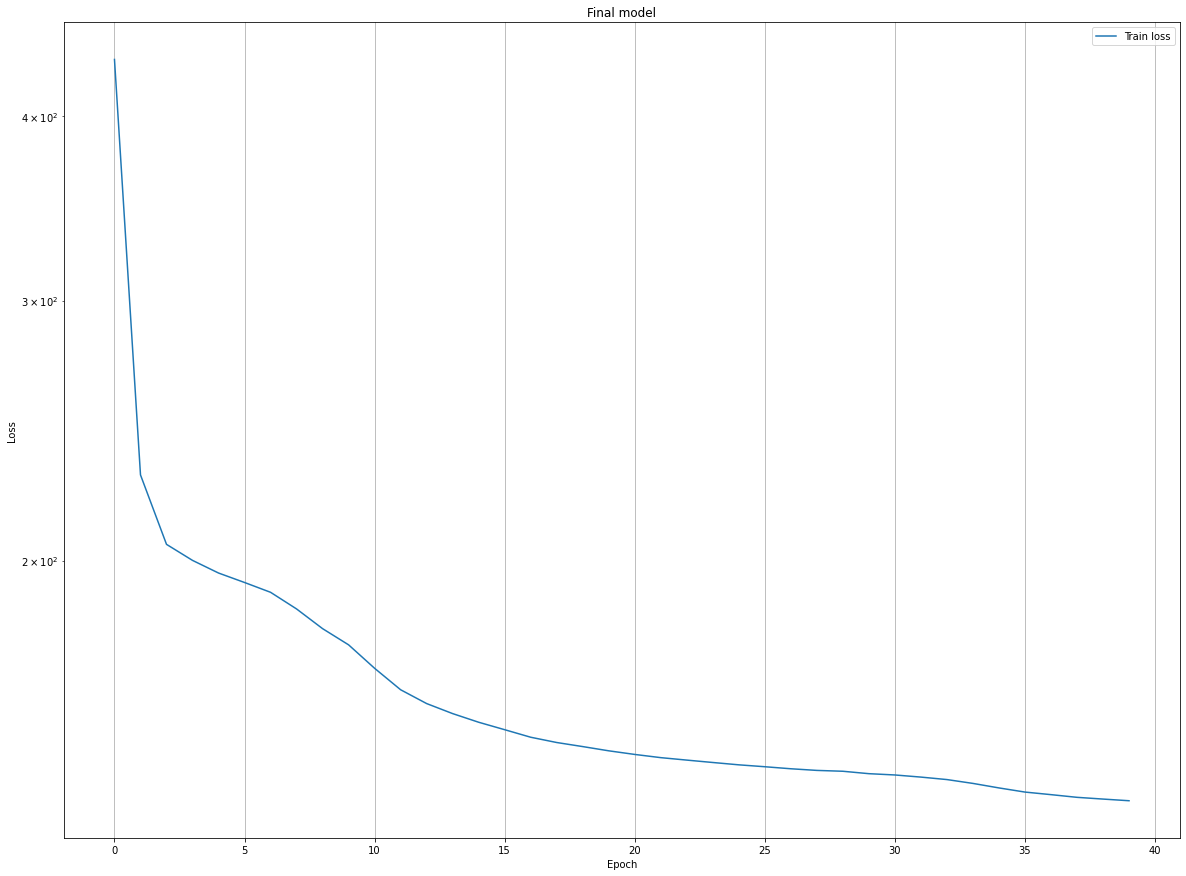

In [ ]:
plt.figure(figsize=(20,15))
plt.title('Final model')
plt.semilogy(train_loss, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

##Image recontruction

In [ ]:
def rec_img_show(idx):
  img = test_dataset[idx][0].unsqueeze(0).to(device)
  encoder_vae.eval()
  decoder_vae.eval()
  with torch.no_grad():
    encoded_data, _, _ = encoder_vae(img)
    rec_img  = decoder_vae(encoded_data)

  # Plot the original image and the reconstructed one
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0].set_title('Original image')
  axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[1].set_title('Reconstructed image')
  plt.tight_layout()
  plt.show()

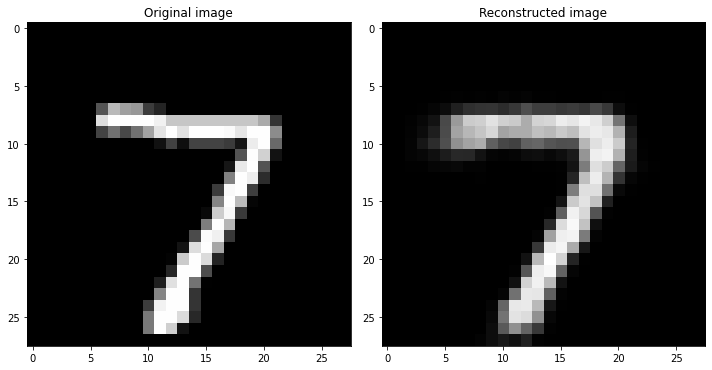

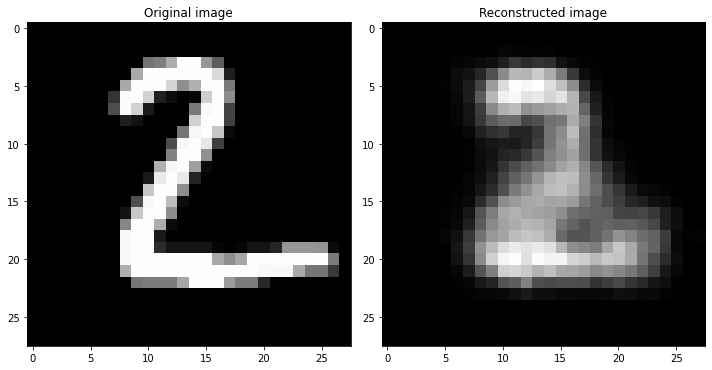

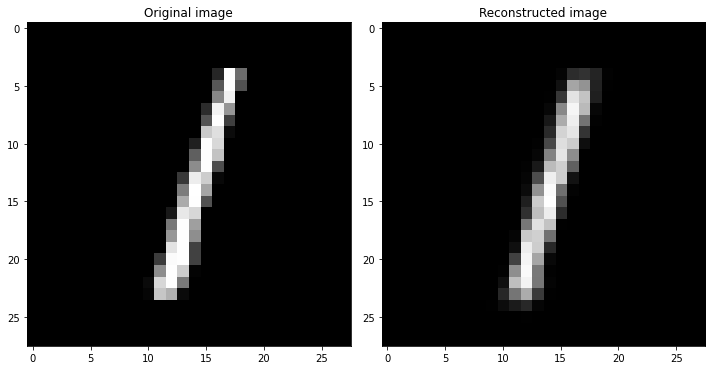

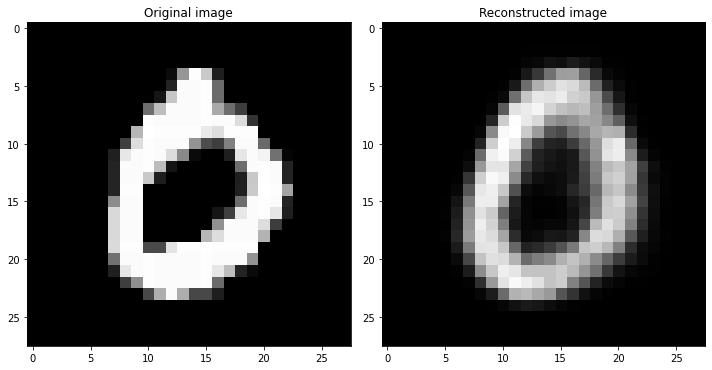

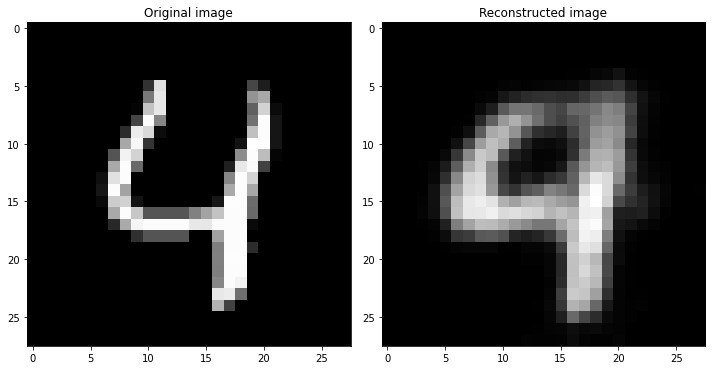

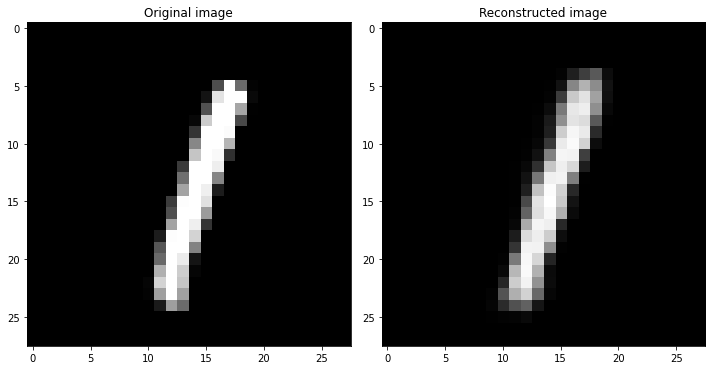

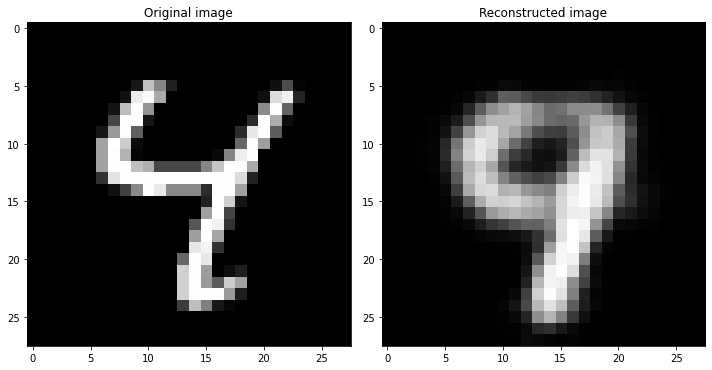

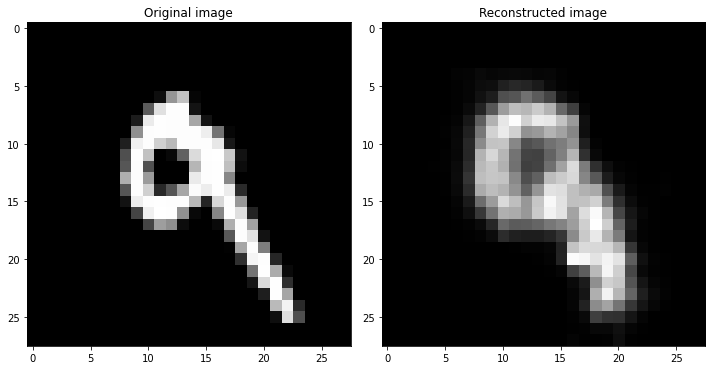

In [ ]:
rec_img_show(0)
rec_img_show(1)
rec_img_show(2)
rec_img_show(3)
rec_img_show(4)
rec_img_show(5)
rec_img_show(6)
rec_img_show(7)

##Sample from latent code

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
encoded_labels = []
for sample in test_dataset:
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]
  # Encode image
  encoder_vae.eval()
  with torch.no_grad():
      encoded_img, _, _  = encoder_vae(img)

  # Append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_labels.append(label)
  encoded_samples.append(encoded_img)

encoded_samples = np.array(encoded_samples)
encoded_labels = np.array(encoded_labels)

This is the version with same min/max (see the report for explanation)

In [ ]:
max_value = max(map(max, encoded_samples))
min_value = min(map(min, encoded_samples))

def generate_code(dimensionality=5):
  code = []
  for idx in range(dimensionality):
    code.append(random.uniform(min_value, max_value))
  return code

def generate_img(code): 
  # Generate a custom sample
  encoded_value = torch.tensor(code).float().unsqueeze(0).to(device)

  # Decode sample
  decoder_vae.eval()
  with torch.no_grad():
      generated_img  = decoder_vae(encoded_value)

  return generated_img

def code_to_string(code):
  code_str = ''
  for x in code:
    code_str = code_str + str(x) + '\n'
  return code_str

def generate_img_grid():
  fig, axs = plt.subplots(5, 5, figsize=(20,20))
  idx = 1
  for i in range(5):
    for j in range(5):
      code = generate_code()
      axs[i][j].imshow(generate_img(code).cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i][j].set_title(f'Digit {idx}\n' + code_to_string(code))
      idx += 1
  plt.tight_layout()
  plt.show()

generate_img_grid()

This is the version with different min/max (see the report for explanation)

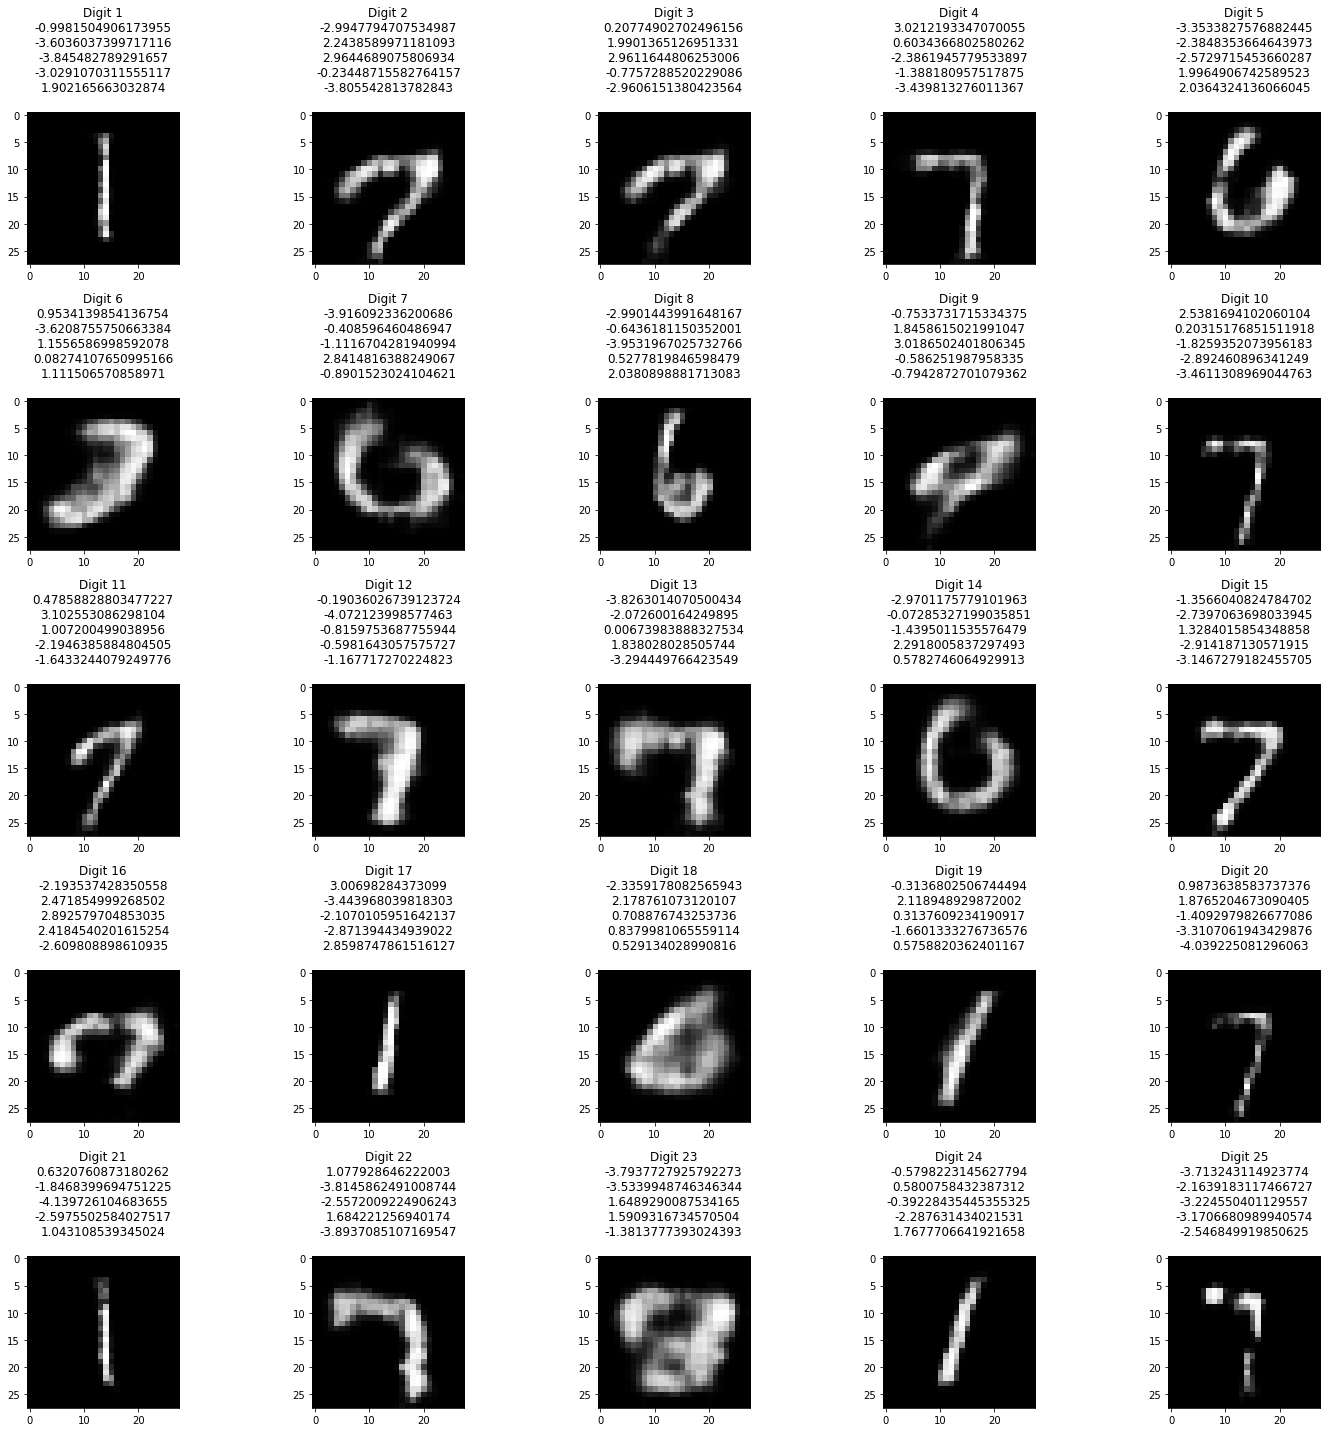

In [ ]:
max_value = []
min_value = []

def extract_extremes(dimensionality=5):
  for idx in range(dimensionality):
    ax = encoded_samples[:, idx]
    max_value.append(np.max(ax))
    min_value.append(np.min(ax))
  print('min', min_value)
  print('max', max_value)

def generate_code(dimensionality=5):
  code = []
  for idx in range(dimensionality):
    code.append(random.uniform(min_value[idx], max_value[idx]))
  return code

def generate_img(code): 
  # Generate a custom sample
  encoded_value = torch.tensor(code).float().unsqueeze(0).to(device)

  # Decode sample
  decoder_vae.eval()
  with torch.no_grad():
      generated_img  = decoder_vae(encoded_value)

  return generated_img

def code_to_string(code):
  code_str = ''
  for x in code:
    code_str = code_str + str(x) + '\n'
  return code_str

def generate_img_grid():
  fig, axs = plt.subplots(5, 5, figsize=(20,20))
  idx = 1
  for i in range(5):
    for j in range(5):
      code = generate_code()
      axs[i][j].imshow(generate_img(code).cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i][j].set_title(f'Digit {idx}\n' + code_to_string(code))
      idx += 1
  plt.tight_layout()
  plt.show()

extract_extremes()
generate_img_grid()